<a href="https://colab.research.google.com/github/atmark-techno/armadillo-iot-g4_model_zoo/blob/main/GoogleColabNotebooks/ObjectDetection_OperationCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## モデルのダウンロード

In [1]:
%%bash
wget http://storage.googleapis.com/download.tensorflow.org/models/tflite/coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
unzip coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
rm coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip

Archive:  coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
  inflating: detect.tflite           
  inflating: labelmap.txt            


--2022-08-16 04:15:54--  http://storage.googleapis.com/download.tensorflow.org/models/tflite/coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2807218 (2.7M) [application/zip]
Saving to: ‘coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip’

     0K .......... .......... .......... .......... ..........  1% 22.3M 0s
    50K .......... .......... .......... .......... ..........  3% 24.9M 0s
   100K .......... .......... .......... .......... ..........  5% 24.3M 0s
   150K .......... .......... .......... .......... ..........  7% 7.71M 0s
   200K .......... .......... .......... .......... ..........  9% 23.9M 0s
   250K .......... .......... .......... .......... .......... 10% 13.4M 0s
   300K .......... .......... .......... ...

## テスト画像のダウンロード

In [2]:
# テスト画像をtest.jpgという名前で保存します。
%%bash
wget "https://unsplash.com/photos/OFyh9TpMyM8/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYwNjExMDAz&force=true&w=1920" -O test.jpg

--2022-08-16 04:15:54--  https://unsplash.com/photos/OFyh9TpMyM8/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYwNjExMDAz&force=true&w=1920
Resolving unsplash.com (unsplash.com)... 151.101.129.181, 151.101.1.181, 151.101.65.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.129.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1541625602330-2277a4c46182?ixlib=rb-1.2.1&dl=coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb [following]
--2022-08-16 04:15:54--  https://images.unsplash.com/photo-1541625602330-2277a4c46182?ixlib=rb-1.2.1&dl=coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb
Resolving images.unsplash.com (images.unsplash.com)... 146.75.82.208, 2a04:4e42:83::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.82.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348978 (341K) [image/jpeg]


## テストコード

### ライブラリのインポート

In [3]:
from tensorflow.lite.python.interpreter import Interpreter # Armadillo-IoT ゲートウェイ G4 実機上では、"from tflite_runtime import Interpreter" としてインポートしてください。
import cv2
import numpy as np
import re
from google.colab.patches import cv2_imshow # Google colab上でcv2画像を表示するために必要なライブラリ

### interpreterの準備

In [4]:
interpreter = Interpreter('detect.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

_, i_height, i_width, _ = input_details[0]['shape']

[{'name': 'normalized_input_image_tensor', 'index': 175, 'shape': array([  1, 300, 300,   3], dtype=int32), 'shape_signature': array([  1, 300, 300,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128), 'quantization_parameters': {'scales': array([0.0078125], dtype=float32), 'zero_points': array([128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'TFLite_Detection_PostProcess', 'index': 167, 'shape': array([ 1, 10,  4], dtype=int32), 'shape_signature': array([ 1, 10,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'TFLite_Detection_PostProcess:1', 'index': 168, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parame

### labelmap.txtからindexとlabelの対応関係を抽出

In [5]:
labels = {}
with open('labelmap.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for row_number, content in enumerate(lines):
        pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
        if len(pair) == 2 and pair[0].strip().isdigit():
            labels[int(pair[0]) - 1] = pair[1].strip()
        else:
            labels[row_number - 1] = pair[0].strip()
    removed_value = labels.pop(-1)
print(labels)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic', 10: 'fire', 11: '???', 12: 'stop', 13: 'parking', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: '???', 26: 'backpack', 27: 'umbrella', 28: '???', 29: '???', 30: 'handbag', 31: 'tie', 32: 'suitcase', 33: 'frisbee', 34: 'skis', 35: 'snowboard', 36: 'sports', 37: 'kite', 38: 'baseball', 39: 'baseball', 40: 'skateboard', 41: 'surfboard', 42: 'tennis', 43: 'bottle', 44: '???', 45: 'wine', 46: 'cup', 47: 'fork', 48: 'knife', 49: 'spoon', 50: 'bowl', 51: 'banana', 52: 'apple', 53: 'sandwich', 54: 'orange', 55: 'broccoli', 56: 'carrot', 57: 'hot', 58: 'pizza', 59: 'donut', 60: 'cake', 61: 'chair', 62: 'couch', 63: 'potted', 64: 'bed', 65: '???', 66: 'dining', 67: '???', 68: '???', 69: 'toilet', 70: '???', 71: 'tv', 72: 'laptop', 73: 'mouse', 74: 'remote', 75: 'keyboard',

### テスト画像を読み込み、モデルに入力する形に整形する

In [6]:
img = cv2.imread('test.jpg')
src_height, src_width, _ = img.shape # 最後に必要になるので入力画像のサイズを取得しておく
input_image = cv2.resize(img, (i_height, i_width)) # モデルの入力サイズにリサイズ
input_image = np.expand_dims(input_image, 0)
input_image = input_image.astype(input_details[0]['dtype'])

### 推論実行

In [7]:
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

### 推論結果を抽出

In [8]:
boxes = interpreter.get_tensor(output_details[0]['index']).squeeze()   # bounding boxの座標。(y1, x1, y2, x2)の順番
classes = interpreter.get_tensor(output_details[1]['index']).squeeze() # 検出した物体が何かをlabelmap.txtと対応する数値で表している
scores = interpreter.get_tensor(output_details[2]['index']).squeeze()  # 検出した物体がどれくらいの確率でその物体であるかを0~1の間の数値で表している
count = interpreter.get_tensor(output_details[3]['index']).squeeze()   # いくつの物体を検出したかを表している。最大で10。今回は使用しない。

In [9]:
res = []
threshold = 0.6 # 0~1の間で指定。ここで指定した値未満のscoreを持つ推論結果は描画しない
for box, score, class_ in zip(boxes, scores, classes):
    if score < threshold:
        break
    d = {}
    y1, x1, y2, x2 = box
    x1 = int(x1 * src_width)
    x2 = int(x2 * src_width)
    y1 = int(y1 * src_height)
    y2 = int(y2 * src_height)
    d['box'] = [x1, y1, x2, y2]
    d['score'] = score
    d['label'] = labels[int(class_)]
    res.append(d)
print(res)

[{'box': [306, 482, 993, 1092], 'score': 0.80078125, 'label': 'bicycle'}, {'box': [90, 529, 738, 1068], 'score': 0.7578125, 'label': 'bicycle'}, {'box': [633, 214, 961, 978], 'score': 0.75, 'label': 'person'}, {'box': [152, 183, 587, 960], 'score': 0.6875, 'label': 'person'}]


### 推論結果を元画像に描画

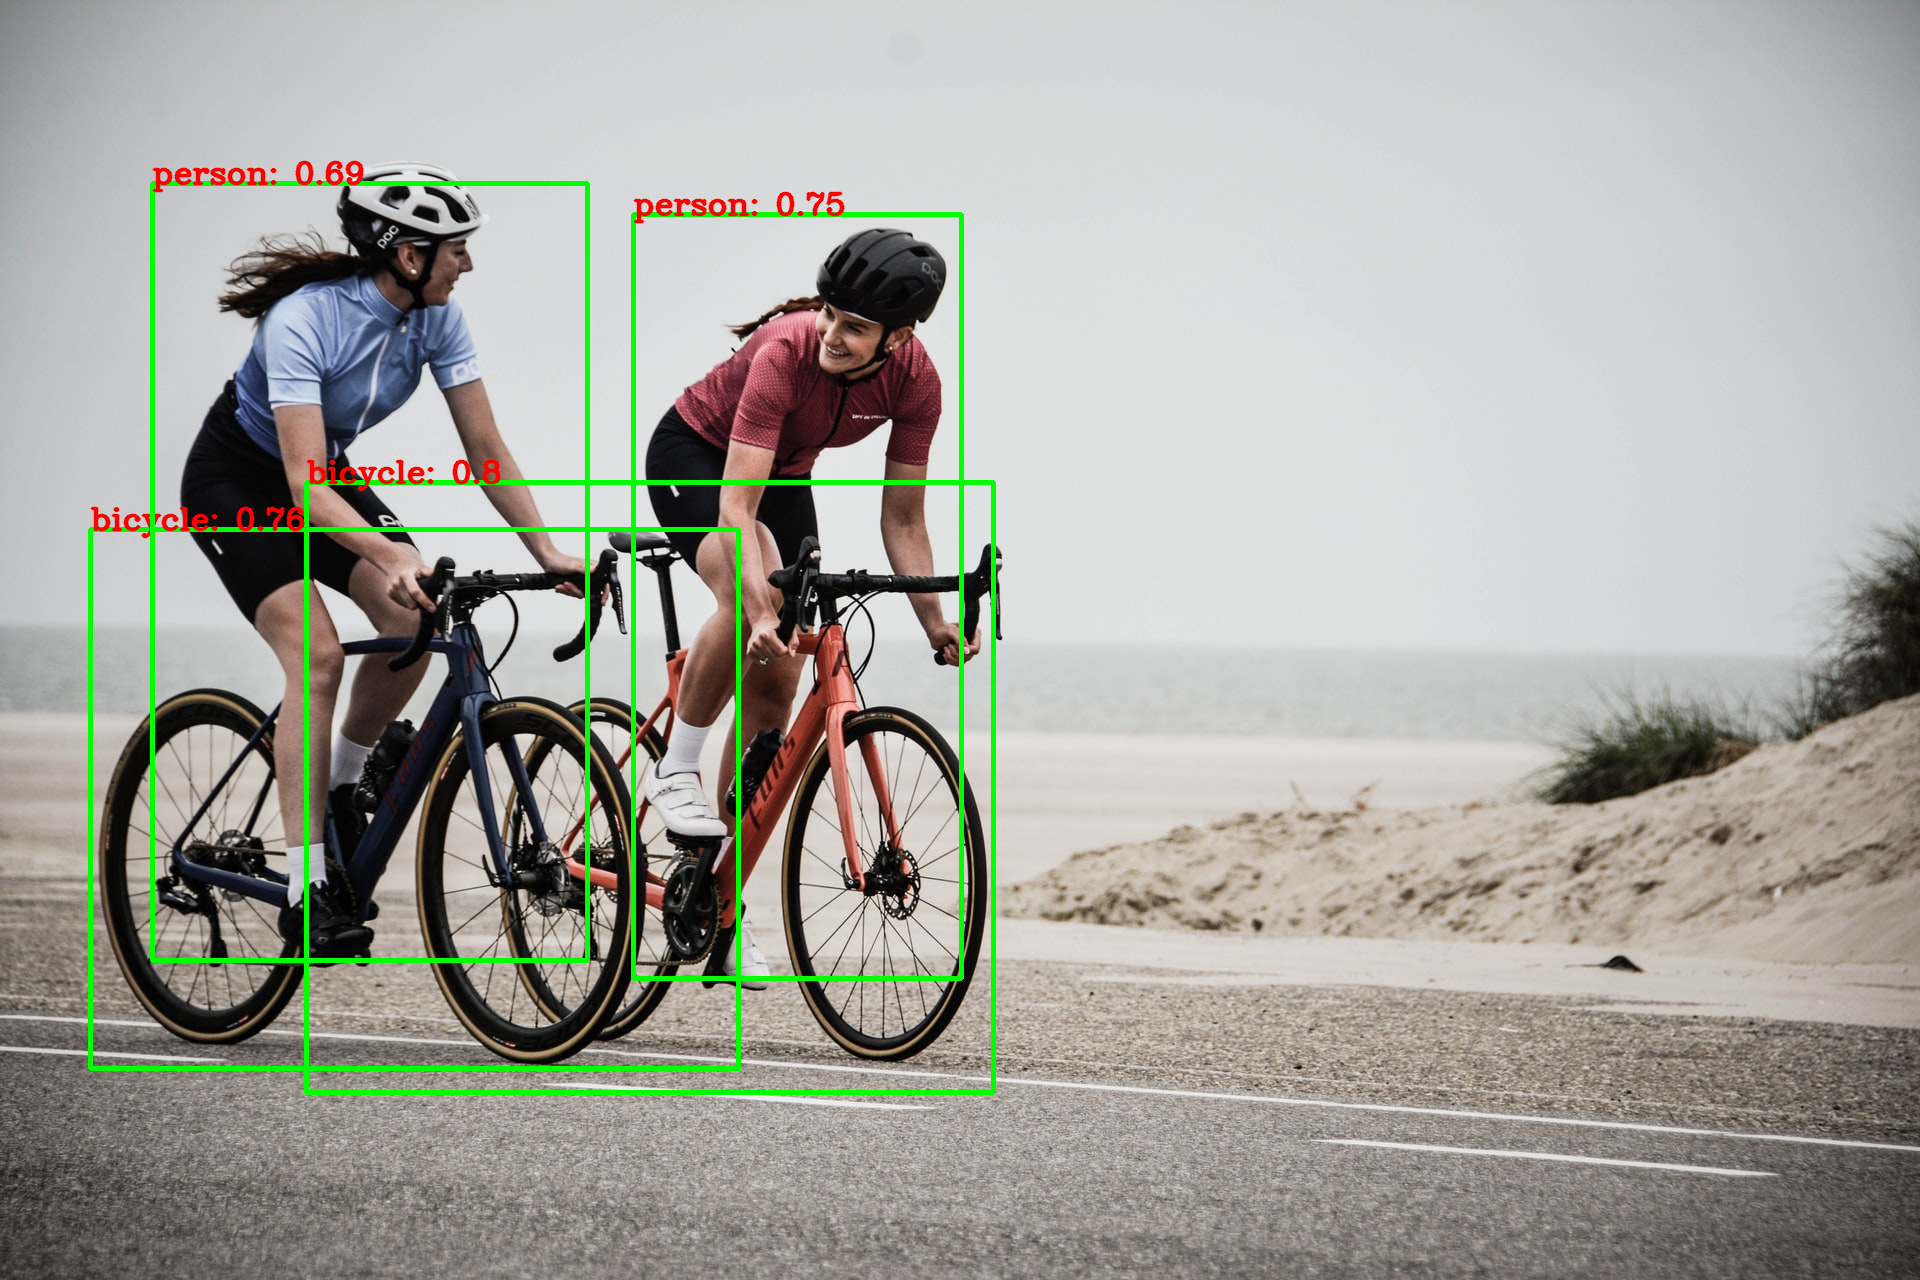

In [10]:
output_image = img.copy()
for r in res:
    box_coord = r['box']
    score = r['score']
    label = r['label']
    # bounding boxの描画
    cv2.rectangle(
        output_image,
        pt1=(box_coord[0:2]),
        pt2=(box_coord[2:4]),
        color=(0, 255, 0),
        thickness=3,
        lineType=cv2.LINE_4,
        shift=0
    )
    # labelとscoreの描画
    text = '{}: {:.2}'.format(label, score)
    cv2.putText(
        output_image,
        text=text,
        org=(box_coord[0:2]),
        fontFace=cv2.FONT_HERSHEY_COMPLEX,
        fontScale=1,
        color=(0, 0, 255),
        thickness=2,
        lineType=cv2.LINE_AA
    )
# 結果の描画
cv2_imshow(output_image)